### Intro to Probabilistic graphical models

PGMs are generative models that can compute the joint distribution among random variables in a system by explotiing the conditional indpendence relationship between variables to create a graph structure representing the relationships between different random variables.

Graph structures can be directed, undirected or both and have a set of parameters associated with each variable (local conditional probabilities).

There are mainly 2 types of graphical models: 

1. Markov Models: A Markov Models consists of an undirected graph and are parameterized by Factors. Factors
represent how much 2 or more variables agree with each other.

     e.g. Markov networks, Markov chains, HMM
     

2. Bayesian Models: A Bayesian Model consists of a directed graph and Conditional Probability Distributions(CPDs) associated with each of the node.

     e.g. Discrete Bayesian Network, Continuous Bayesian Network, Dynamic BN (special case of HMM)

#### Markov Chains

In [60]:
import networkx as nx
import pandas as pd
from pomegranate import ConditionalProbabilityTable, DiscreteDistribution, MarkovChain
import datetime
import os
from pathlib import Path
import matplotlib.cm as cm

import matplotlib.pyplot as plt
import numpy as np
import prefect
from matplotlib.dates import YearLocator
from hmmlearn.hmm import GaussianHMM, MultinomialHMM
import pandas_datareader.data as web
from prefect import Flow, task
from matplotlib.dates import MonthLocator, YearLocator
import numpy as np
import pandas as pd
from pgmpy.models import NaiveBayes
import random
import numpy as np
import logging
import pyvis
from pyvis.network import Network


def initialise_markov_chain(prior_prob, cpd):
    d1 = DiscreteDistribution(prior_prob)
    d2 = ConditionalProbabilityTable(cpd, [d1])
    clf = MarkovChain([d1, d2])
    return clf


def compute_probability_sequence(seq, clf):
    print(clf.log_probability(seq))


def generate_random_sample_from_model(clf, length, num_seqs):
    df = pd.DataFrame(columns=["sequences"])
    for i in range(num_seqs):
        obs = clf.sample(length)
        df = df.append({"sequences": obs}, ignore_index=True)
    return df


def build_markov_chain_from_data(df):
    seq = list(df["sequences"])
    model = MarkovChain.from_samples(seq)
    return model


def create_markov_networkx_object(model):
    cpd = model.distributions[1].to_dict()["table"]
    states = list(model.distributions[0].to_dict()["parameters"][0].keys())
    G = nx.MultiDiGraph()
    G.add_nodes_from(states)
    for k, l, v in cpd:
        tmp_origin, tmp_destination = k, l
        G.add_edge(tmp_origin, tmp_destination, weight=v, label=v[0:4])
        color = "red"
       
    return G



def draw_network(G, node_color, edge_color, notebook=True, physics=True, config=None):
    nx.set_node_attributes(G, node_color, name="color")
    nx.set_edge_attributes(G, edge_color, name="color")
    if notebook:
        nt = Network(notebook=True)
    else:
        nt = Network()
    if physics:
        nt.show_buttons(filter_=['physics'])
    nt.from_nx(G)
    if config is not None:
        nt.set_options(config) 
    return nt

In [2]:

A = "Sleep" 
B = "Eat"
C = "Run"

prior_prob = {A: 0.5, B: 0.2, C: 0.3}
cpd = [
    [A, A, 0.10],
    [A, B, 0.50],
    [A, C, 0.30],
    [B, A, 0.10],
    [B, B, 0.40],
    [B, C, 0.40],
    [C, A, 0.05],
    [C, B, 0.45],
    [C, C, 0.45],
]


In [12]:
clf = initialise_markov_chain(prior_prob, cpd)

clf.distributions[1]

{
    "class" : "Distribution",
    "name" : "ConditionalProbabilityTable",
    "table" : [
        [
            "Sleep",
            "Sleep",
            "0.10000000000000002"
        ],
        [
            "Sleep",
            "Eat",
            "0.5"
        ],
        [
            "Sleep",
            "Run",
            "0.3"
        ],
        [
            "Eat",
            "Sleep",
            "0.10000000000000002"
        ],
        [
            "Eat",
            "Eat",
            "0.4"
        ],
        [
            "Eat",
            "Run",
            "0.4"
        ],
        [
            "Run",
            "Sleep",
            "0.05000000000000001"
        ],
        [
            "Run",
            "Eat",
            "0.45"
        ],
        [
            "Run",
            "Run",
            "0.45"
        ]
    ],
    "dtypes" : [
        "str",
        "str",
        "float"
    ],
    "parents" : [
        {
            "class" : "Distribution",
           

In [13]:

G = create_markov_networkx_object(clf)
G.edges.data('weight')


OutMultiEdgeDataView([('Sleep', 'Sleep', '0.10000000000000002'), ('Sleep', 'Eat', '0.5'), ('Sleep', 'Run', '0.3'), ('Eat', 'Sleep', '0.10000000000000002'), ('Eat', 'Eat', '0.4'), ('Eat', 'Run', '0.4'), ('Run', 'Sleep', '0.05000000000000001'), ('Run', 'Eat', '0.45'), ('Run', 'Run', '0.45')])

In [14]:
nt = draw_network(G, "red", "green", notebook=True, physics=True, config=None)
nt.show('outputs/markov_chain.html')

We have a state based model with the probability distributions set earlier. We can use this model to draw random samples/seqeunces

In [29]:
df = generate_random_sample_from_model(clf, length=4, num_seqs=100)
df

,sequences
0,"[Sleep, Eat, Run, Eat]"
1,"[Sleep, Sleep, Run, Run]"
2,"[Sleep, Eat, Eat, Run]"
3,"[Run, Eat, Sleep, Sleep]"
4,"[Run, Run, Eat, Run]"
...,...
95,"[Sleep, Eat, Eat, Sleep]"
96,"[Run, Run, Eat, Eat]"
97,"[Run, Run, Eat, Eat]"
98,"[Sleep, Run, Eat, Sleep]"


In [30]:
model_from_data = build_markov_chain_from_data(df)
print('Model from data')
print('')
print(model_from_data.distributions[1])
print('')
print('Original model')
print('')
print(clf.distributions[1])

Model from data

Run	Run	0.45528455284552843
Run	Eat	0.5040650406504065
Run	Sleep	0.04065040650406505
Eat	Run	0.48695652173913045
Eat	Eat	0.4
Eat	Sleep	0.11304347826086955
Sleep	Run	0.3387096774193548
Sleep	Eat	0.532258064516129
Sleep	Sleep	0.12903225806451615

Original model

Run	Run	0.46001719690455717
Run	Eat	0.48753224419604474
Run	Sleep	0.05245055889939811
Eat	Run	0.444064901793339
Eat	Eat	0.4466268146883006
Eat	Sleep	0.10930828351836036
Sleep	Run	0.36336336336336345
Sleep	Eat	0.524024024024024
Sleep	Sleep	0.11261261261261261


### Hidden Markov Models

https://www.cs.ubc.ca/~murphyk/Bayes/rabiner.pdf


There are three fundamental problems for HMMs:

1) Given the model parameters and observed data, estimate the optimal sequence of hidden states. 

2) Given the model parameters and observed data, calculate the likelihood of the data. 

3) Given just the observed data, estimate the model parameters.

#### Discrete HMM

In [34]:

states = ["Rainy", "Sunny"]
n_states = len(states)
observations = ["walk", "shop", "clean"]
n_observations = len(observations)
start_probability = np.array([0.6, 0.4])
transition_probability = np.array([[0.7, 0.3], [0.4, 0.6]])
emission_probability = np.array([[0.1, 0.4, 0.5], [0.6, 0.3, 0.1]])


def _get_markov_edges(Q):
    """
    function that maps transition probability dataframe
    to markov edges and weights
    """
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx, col)] = Q.loc[idx, col]
    return edges


def generate_random_seq_of_observations():
    seq = []
    lengths = []
    for _ in range(100):
        length = random.randint(5, 10)
        lengths.append(length)
        for _ in range(length):
            r = random.random()
            if r < 0.2:
                seq.append(0)  # walk
            elif r < 0.6:
                seq.append(1)  # shop
            else:
                seq.append(2)  # clean
    seq = np.array([seq]).T
    return seq, lengths


def is_converged(hmm_model):
    return hmm_model.monitor_.converged


def train_discrete_hmm(
    X,
    lengths,
    start_probability,
    transition_probability,
    emission_probability,
    components=3,
    iterations=15,
    verbose=True,
):
    model = MultinomialHMM(components, iterations, verbose, init_params="mc")
    model.startprob_ = start_probability
    model.transmat_ = transition_probability
    model.emissionprob_ = emission_probability
    print(
        f"commencing hmm model training with parameters- "
        f"Iterations: {iterations}, components: {components}"
    )
    model.fit(X, lengths)
    if is_converged(model):
        print("model has converged")
        print(' ')
        print(model.transmat_)
        print(model.emissionprob_)
        print(model.startprob_)
    return model


def decode_hidden_state_for_discrete_hmm(encoded_obs_seq, observations, states, model):
    logprob, hidden_states = model.decode(encoded_obs_seq, algorithm="viterbi")
    print(
        "Observed behaviour:",
        ", ".join(map(lambda x: observations[x], encoded_obs_seq.T[0])),
    )
    print("Inferred hidden states:", ", ".join(map(lambda x: states[x], hidden_states)))
    return logprob, hidden_states



###### Given just the observed data, estimate the model parameters.

In [35]:
seq, lengths = generate_random_seq_of_observations()

In [36]:
        model = train_discrete_hmm(
            seq,
            lengths,
            start_probability,
            transition_probability,
            emission_probability,
            components=n_states,
            iterations=30,
            verbose=True,
        )

commencing hmm model training with parameters- Iterations: 30, components: 2
model has converged
 
[[0.66248678 0.33751322]
 [0.49836093 0.50163907]]
[[0.07788276 0.39269907 0.52941818]
 [0.40823979 0.41537576 0.17638445]]
[0.57223381 0.42776619]


###### Given the model parameters and observed data, estimate the optimal sequence of hidden states.

In [37]:
obs_states = np.array([[0, 2, 1, 1, 2, 0]]).T
decode_hidden_state_for_discrete_hmm(obs_states, observations, states, model)


Observed behaviour: walk, clean, shop, shop, clean, walk
Inferred hidden states: Sunny, Rainy, Rainy, Rainy, Rainy, Sunny


(-8.800201673262634, array([1, 0, 0, 0, 0, 1], dtype=int32))

### Regime Detection

The goal of the Hidden Markov Model will be to identify when the regime has switched from bullish to bearish and vice versa.

The problem of Regime Detection is actually an unsupervised learning challenge since the number of states is not known a priori, nor is there any "ground truth" on which to "train" the HMM.

In this section we will fit a Gaussian HMM to yahoo stock market data and then decode the hidden states (regimes) from the observed returns

In [79]:
import pandas_datareader.data as web

def get_quotes_data_finance(start, end):

    Stocks = web.DataReader('GE', 'yahoo', start=start, end=end) 
    Stocks.reset_index(inplace=True, drop=False)
    return Stocks

def process_and_plot_stocks_data(Stocks):
    Stocks = Stocks.drop(["Open", "High", "Low", "Adj Close"], axis=1)
    Stocks = list(Stocks.itertuples(index=False, name=None))
    dates = np.array([q[0] for q in Stocks])
    end_val = np.array([q[1] for q in Stocks])
    volume = np.array([q[2] for q in Stocks])[1:]
    diff = np.diff(end_val)
    dates = dates[1:]
    end_val = end_val[1:]
    X = np.column_stack([diff, volume])
    plt.figure(figsize=(15, 5), dpi=100)
    plt.gca().xaxis.set_major_locator(YearLocator())
    plt.plot_date(dates, end_val, "-")
    plt.show()
    return X, dates, end_val


def train_gaussian_hmm(X, components=4, iter=1000):
    model = GaussianHMM(
        n_components=components, covariance_type="diag", n_iter=iter
    ).fit(X)
    return model


def compute_mean_and_vars_hidden_state(model):
    for i in range(model.n_components):
        print("{0}th hidden state".format(i))
        print("mean = ", model.means_[i])
        print("var = ", np.diag(model.covars_[i]))

def decode_hidden_states_time_series(X, model):
    hidden_states = model.predict(X)
    print(model.transmat_)
    return hidden_states


def plot_trained_parameters(model, hidden_states, dates, end_val, figsize):
    fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=figsize)
    colours = cm.rainbow(np.linspace(0, 1, model.n_components))
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        # Use fancy indexing to plot data in each state.
        mask = hidden_states == i
        ax.plot_date(dates[mask], end_val[mask], ".-", c=colour)
        ax.set_title("{0}th hidden state".format(i))

        # Format the ticks.
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()


Here the pandas_datareader library is used to fetch Yahoo Finance provides stock market data but has a rich source of stockd and shares data from various platforms. 
https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

In [72]:

start_date = datetime.date(2003, 7, 1)
end_date = datetime.date(2017, 7, 1)

stocks = get_quotes_data_finance(start_date, end_date)
stocks

,Date,High,Low,Open,Close,Volume,Adj Close
0,2003-07-01,221.538467,216.000000,219.076920,220.230774,2708576.0,130.003067
1,2003-07-02,222.153839,218.615387,221.692307,220.076920,2836535.0,129.912231
2,2003-07-03,221.538467,218.538467,220.153839,219.615387,1598311.0,129.639847
3,2003-07-07,226.923080,222.076920,222.538467,225.153839,2548741.0,132.909180
4,2003-07-08,225.153839,220.384613,225.153839,221.615387,2971813.0,130.820389
...,...,...,...,...,...,...,...
3521,2017-06-26,212.923080,211.538467,212.230774,212.384613,3705208.0,200.796585
3522,2017-06-27,212.230774,209.230774,211.692307,209.307693,5372822.0,197.887543
3523,2017-06-28,210.769226,208.076920,209.692307,208.307693,4032054.0,196.942123
3524,2017-06-29,210.846161,206.076920,208.923080,207.846161,4775173.0,196.505768


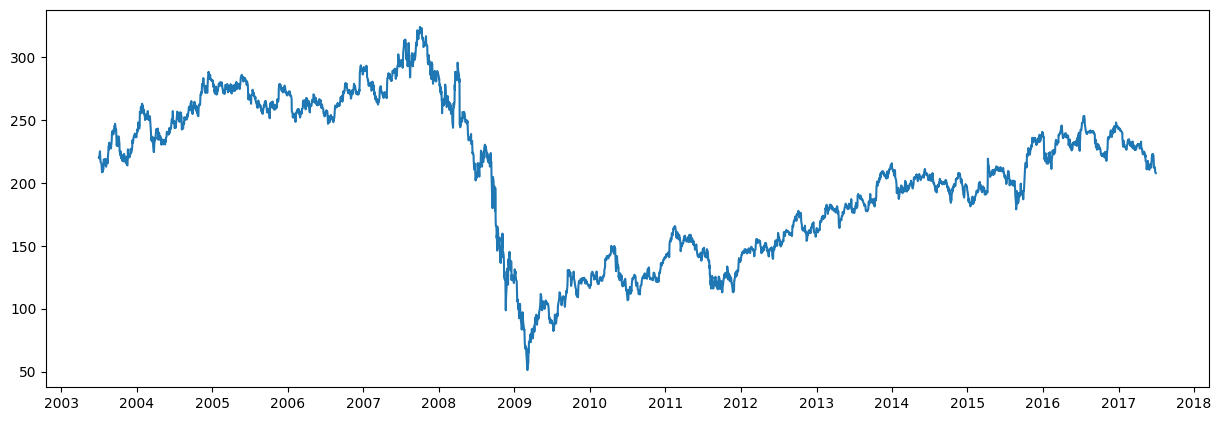

In [80]:
X, dates, end_val = process_and_plot_stocks_data(stocks)


In [75]:
model = train_gaussian_hmm(X)
hidden_states = decode_hidden_states_time_series(X, model)


[[8.85875761e-01 8.13717193e-02 3.18663765e-02 8.86143408e-04]
 [1.14742944e-01 8.40794729e-01 2.40352562e-03 4.20588016e-02]
 [4.35937774e-02 4.48711183e-03 9.51919111e-01 7.19217409e-26]
 [1.18347190e-15 1.54197875e-01 1.10787239e-69 8.45802125e-01]]


In [76]:
compute_mean_and_vars_hidden_state(model)

0th hidden state
mean =  [-3.54294052e-02  4.49445234e+06]
var =  [3.54320070e+00 1.00824712e+12]
1th hidden state
mean =  [9.41509277e-02 8.23985729e+06]
var =  [1.07192109e+01 5.19500718e+12]
2th hidden state
mean =  [6.11691408e-02 2.60713530e+06]
var =  [4.46850650e+00 4.07108952e+11]
3th hidden state
mean =  [-4.21475153e-01  1.97435381e+07]
var =  [3.95203321e+01 1.06884636e+14]


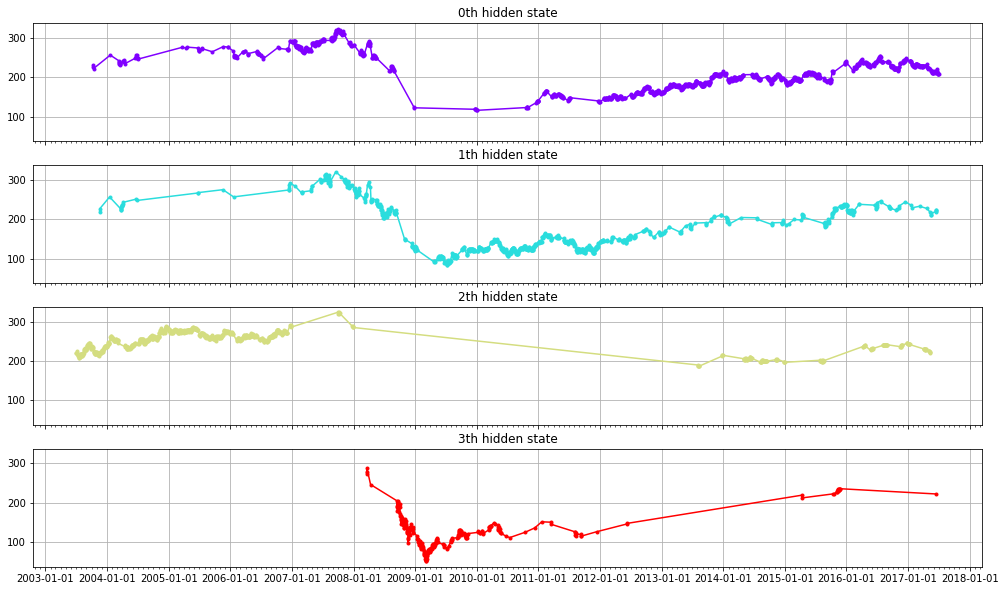

In [77]:

plot_trained_parameters(model, hidden_states, dates, end_val, (17,10))

### Markov Networks/Random fields

In [46]:
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
student = MarkovNetwork([('Mary', 'Bob'), ('Bob', 'Will')])
factor1 = DiscreteFactor(['Mary', 'Bob'], cardinality=[2, 2],
                         values=np.random.rand(4))
factor2 = DiscreteFactor(['Bob', 'Will'], cardinality=[2, 3],
                         values=np.ones(6))
student.add_factors(factor1,factor2)
student.get_factors()

nt = draw_network(student, "red", "green", notebook=True, physics=True, config=None)
nt.show('outputs/markov_network.html')
       